In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/hate_speech

/content/drive/MyDrive/hate_speech


In [3]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 8.1 MB/s 
     |████████████████████████████████| 636 kB 55.4 MB/s 
     |████████████████████████████████| 3.3 MB 46.2 MB/s 
     |████████████████████████████████| 895 kB 74.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [22]:
import nltk
import csv
import torch
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler

import os

In [5]:
df = pd.read_csv('test_hatespeech.csv')
df.set_index('id', inplace = True)
print(df.Label.value_counts())

none      2186
sexism     633
racism     387
Name: Label, dtype: int64


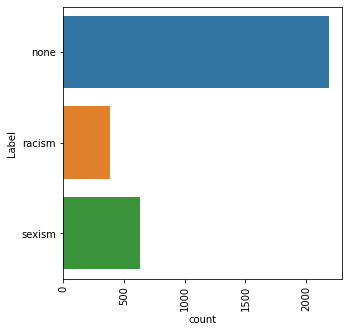

In [6]:
import seaborn as sns
plt.figure(figsize=(5,5))
plt.xticks(rotation=90)
sns.countplot(y="Label", data=df)

In [7]:
possible_labels = df.Label.unique()
label_dict={}
for index,possible_label in enumerate(possible_labels):
  label_dict[possible_label] = index

df['label_id'] = df.Label.replace(label_dict)
df.head()

,Tweets,Label,label_id
id,,,
5014,#mkr at least there are judging honestly,none,0
5015,At the end of this Steve is going to run away ...,none,0
5016,Catching up on #MKR. Did Nikki &amp; Katie get...,none,0
5017,Has anyone made a Twitter account for Rob's ha...,none,0
5020,Will someone pls assist Colin in the washing o...,none,0


In [8]:
df ['data_type'] = "val"
df

,Tweets,Label,label_id,data_type
id,,,,
5014,#mkr at least there are judging honestly,none,0,val
5015,At the end of this Steve is going to run away ...,none,0,val
5016,Catching up on #MKR. Did Nikki &amp; Katie get...,none,0,val
5017,Has anyone made a Twitter account for Rob's ha...,none,0,val
5020,Will someone pls assist Colin in the washing o...,none,0,val
...,...,...,...,...
2557,RT @niamh_bull: #katandandre #mkr far out if s...,sexism,2,val
2558,BAHAHAHA! OMG.. Kat has no idea.... NONE!!! ...,sexism,2,val
2559,RT @daniel_kaye: It's not Kat and Andre - it's...,sexism,2,val


In [9]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == 'val'].Tweets.values,
    add_special_tokens = True,
    return_attention_mask = True,
    padding = 'longest',
    truncation = True,
    return_tensors = 'pt'
)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label_id.values)

dataset_val = TensorDataset(input_ids_val,
                              attention_masks_val,labels_val)


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
df.head()
df.data_type.value_counts()

val    3206
Name: data_type, dtype: int64

In [13]:
batch_size = 8

dataloader_val = DataLoader(
    dataset_val,
    sampler = RandomSampler(dataset_val),
    batch_size = batch_size
)

In [26]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def classification_report_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return classification_report(labels_flat, preds_flat)

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v:k for k,v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    results = {}

    for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat == label]
      y_true = labels_flat[labels_flat == label]
      print(f'Class:{label_dict_inverse[label]}')
      print(f'Accuracy:{len(y_preds[y_preds == label])}/{len(y_true)}\n')
      results[label_dict_inverse[label]] = len(y_preds[y_preds == label])/len(y_true)

    print(f'Overall:{[preds_flat[i] == labels_flat[i] for i in range(len(preds_flat))].count(True)}/{len(preds_flat)}')

    return results

def evaluate(model, dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

Now the evaluation part

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [17]:
model_base = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model_base.to(device)

model_base.load_state_dict(
    torch.load('BERT_ft_epoch3.model',
               map_location = torch.device('cpu'))
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [18]:
model_augmented = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model_augmented.to(device)

model_augmented.load_state_dict(
    torch.load('BERT_augmented_epoch3.model',
               map_location = torch.device('cpu'))
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [19]:
_,predictions_base, true_vals_base = evaluate(model_base, dataloader_val)
base_results = accuracy_per_class(predictions_base, true_vals_base)
print(base_results)

Class:none
Accuracy:1846/2186

Class:racism
Accuracy:331/387

Class:sexism
Accuracy:441/633

Overall:2618/3206
{'none': 0.8444647758462946, 'racism': 0.8552971576227391, 'sexism': 0.6966824644549763}


In [20]:
_,predictions_aug, true_vals_aug = evaluate(model_augmented, dataloader_val)
augmented_results = accuracy_per_class(predictions_aug, true_vals_aug)
print(augmented_results)

Class:none
Accuracy:1820/2186

Class:racism
Accuracy:352/387

Class:sexism
Accuracy:447/633

Overall:2619/3206
{'none': 0.8325709057639524, 'racism': 0.9095607235142119, 'sexism': 0.7061611374407583}


In [21]:
print("--------Base BERT:---------")
base_results = accuracy_per_class(predictions_base, true_vals_base)
# print(base_results)
print("--------BERT + data augmentation:---------")
augmented_results = accuracy_per_class(predictions_aug, true_vals_aug)
# print(augmented_results)

--------Base BERT:---------
Class:none
Accuracy:1846/2186

Class:racism
Accuracy:331/387

Class:sexism
Accuracy:441/633

Overall:2618/3206
--------BERT + data augmentation:---------
Class:none
Accuracy:1820/2186

Class:racism
Accuracy:352/387

Class:sexism
Accuracy:447/633

Overall:2619/3206


In [28]:
print("--------Base BERT:---------")
print(classification_report_func(predictions_base, true_vals_base))
print("--------BERT + data augmentation:---------")
print(classification_report_func(predictions_aug, true_vals_aug))

--------Base BERT:---------
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2186
           1       0.99      0.86      0.92       387
           2       0.57      0.70      0.62       633

    accuracy                           0.82      3206
   macro avg       0.81      0.80      0.80      3206
weighted avg       0.83      0.82      0.82      3206

--------BERT + data augmentation:---------
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      2186
           1       0.91      0.91      0.91       387
           2       0.57      0.71      0.63       633

    accuracy                           0.82      3206
   macro avg       0.79      0.82      0.80      3206
weighted avg       0.83      0.82      0.82      3206

